In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

train = datasets.MNIST("", train=True, download=True,
                  transform = transforms.Compose([
                      transforms.ToTensor()
                  ]))

test = datasets.MNIST("", train=False, download=True,
                  transform = transforms.Compose([
                      transforms.ToTensor()
                  ]))

trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [2]:
# nn provides an OO interface (initialsing) while F is functional (parameters)
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# python: Net inherits methods from nn.Module, calling super will call the nn.Module (parent) init function.

class Net(nn.Module):
    '''
    __init__: 
        - fc1 is fully connected first layer
            - the first layer fc1 is input, it outputs to fc2 so we pass the same size from the output of fc1 to the input of fc2
            - the output layer fc4 has a size of 10 to represent each of our ten digits
        - nn.Linear(input, output), 
            - input (size of each input sample) are our images, each image is 28 by 28 pixels so a flattend image is 28*28=784
            - output (size of each output sample) will have 3 layers of 64 neurons for our hidden layers

    forward: 
        - Feed Forward Network, as simple as it gets, one layers output is passed to the next layers output
        - Most people use the same optimizer function like relu, things change with regards to output, for us the output is multi class and log softmax 
          works to give a probability distribution. Note that the size of the output is the number if outputs, one for each of our ten digits.
        - F.relu() is being run over an entire layers output, relu (rectifide linear) is the activation function or optimizer, it is a sigmoid
          for firing or not firing of 'neurons'
        - F.log_softmax() takes the output and dimension to output a probability distribution, recall that the goal with output 
          is to see which neurons fired, so whichever one is closer to 1 then that is the 'most fired' neuron. Because we are dealing with 
          multiple classes we want a probability distribution on the output.
    '''
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)   # input to hidden
        self.fc2 = nn.Linear(64, 64)      # hidden
        self.fc3 = nn.Linear(64, 64)      # hidden
        self.fc4 = nn.Linear(64, 10)      # hidden to output
        
    def forward(self, x):
        x = F.relu(self.fc1(x))   # x is the output ( nn.Linear(64, x) ), pass result of fc1 to relu
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)           # for the output we want to output a probability distribution

        # probability distribution log_softmax, dimension is 1 as we assume a flat multi dim array tensor for final x (output)
        return F.log_softmax(x, dim=1)
        
        
net = Net()   
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [4]:
X = torch.rand((28,28))
X = X.view(-1, 28*28)    # -1 tells the reshape/view to expect data at any size Tensor(multi dimen array)

In [5]:
output = net(X)

In [6]:
output # these are the outputs !

tensor([[-2.3946, -2.4483, -2.1444, -2.4615, -2.2429, -2.1308, -2.1603, -2.2806,
         -2.4420, -2.4023]], grad_fn=<LogSoftmaxBackward>)

In [7]:
output.max() # max value will be at index, the index is the predicted value

tensor(-2.1308, grad_fn=<MaxBackward1>)

<hr/>

Up to this point, we've gotton the data (builtin dataset), we've built the neural network and passed some data through the neural network and we get a response.

But now we want to pass through labeled data and train the model to be able to recognize hand written digits from data its never seen before.
In order to acheive this, we'll need to learn about loss and the optimizer.

Loss is simply how wrong the model is, the goal with loss is to have it decrease over time.
The optimizers job is to go and adjust the weights that it can, based on the loss (gradients) to lower the loss. Learning rate is the step size.

In [13]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)  # net.parameters() is everything that is adjustable within the model

EPOCHS = 3  # a full pass through of all the data is called an epoch 

for epoch in range(EPOCHS):
    for data in trainset:
        # data is a batch of featuresets and labels (targets)
        # featuresets are the images (X[i]), labels are the class names (y[i]) like a 1,2,3,4,5...
        X, y = data
        # everytime before you pass data through the NN start with a zero gradient
        # zero gradients can help with lowering batch size if hardware resources are limited, the way it does this is that as each wave of data that flows through 
        # the NN the data are added together to calculate weights for each of the features, interupting the flow with a wave of zeros will 'reset' or 'seperate'
        # a data into an artificial batch, more batches are better as it gives the optimizer a way to compare outputs of hidden layers and adjust for loss.
        # the gradients contain the loss, the optimizer uses the gradients to optimize the weights.
        net.zero_grad()
        output = net(X.view(-1, 28*28))
        loss = F.nll_loss(output, y)
        loss.backward()    # back propigate loss over model parameters
        optimizer.step()   # will adjust the weights for us
    print(loss)
        

tensor(0.0509, grad_fn=<NllLossBackward>)
tensor(0.0448, grad_fn=<NllLossBackward>)
tensor(0.0020, grad_fn=<NllLossBackward>)


In [16]:
correct, total = 0, 0

# when validating data we don't want gradients to be calculated, this is out of sample data
# so we use torch with no gradient (no_grad), we just want to know how good the NN is at this point
with torch.no_grad():  
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 28*28))
        for idx, i in enumerate(output):      # i is an output Tensor
            if(torch.argmax(i) == y[idx]):    # if the max value in i is the same at the index of y, then because the digits correspond to their index, correct+=1
                correct += 1
            total += 1

print('Accuracy: ', round(correct/total, 3))

Accuracy:  0.979


Viewing predictions

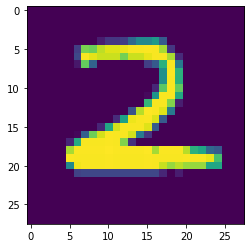

In [26]:
import matplotlib.pyplot as plt
plt.imshow(X[8].view(28,28))
plt.show()

In [27]:
print(torch.argmax(net(X[8].view(-1, 28*28))[0]))

tensor(2, grad_fn=<NotImplemented>)
